<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

## Inhaltsverzeichnis <a id="0"></a> <br>
* [Einleitung](#1) <font color='green'>Done</font>
* [Package- und Datenimport](#2) <font color='green'>Done</font>
* [Deskriptive Analyse](#3)
    * [Datenüberblick](#3.1) <font color='orange'>In Progress</font>
    * [Zusammenfassung der statistischen Kenndaten](#3.2) <font color='orange'>In Progress</font>
    * [Analyse der Kategorischen Variablen](#3.3) <font color='red'>Not started</font>
    * [Zeitreihenanalyse](#3.4) <font color='red'>Not started</font>
    * [Korrelationen](#3.5) <font color='orange'>In Progress</font>
    * [Fehlende Werte und Ausreißer:](#3.6) <font color='orange'>In Progress</font>
* [Daten anpassen](#4) <font color='red'>Not started</font>
* [Geeignete Merkmale](#4) <font color='red'>Not started</font>
* [ML Verfahren 1](#5) <font color='red'>Not started</font>
* [ML Verfahren 2](#6) <font color='red'>Not started</font>
* [Vergleich](#7) <font color='red'>Not started</font>

## 1. Einleitung <a id="1"></a> <br>

Dieses Jupyter Notebook dokumentiert unser Projekt für das Modul Data Mining, in dem wir die Verkaufszahlen der Rossmann-Filialen vorhersagen. Diese Aufgabe basiert auf dem Rossmann Store Sales Datensatz von [Kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), der umfangreiche Verkaufsdaten von über 1000 Filialen enthält. 

Alle verwendeten Quellen werden entsprechend referenziert. Die Nutzung von KI-gestützten Tools ist für dieses Projekt erlaubt und alle Schritte, einschließlich der Prompts, werden dokumentiert.

## 2. Package- und Datenimport <a id="2"></a> <br>

In [87]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white') # Hintergrund der Plots

In [88]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

## 3. Deskriptive Analyse <a id="3"></a> <br>

Der Rossmann Store Sales-Datensatz enthält historische Verkaufsdaten für 1.115 Rossmann-Filialen. Er besteht aus drei CSV-Dateien:

- train.csv: Historische Daten einschließlich Verkäufe
- test.csv: Historische Daten ohne Verkäufe (für die Vorhersage)
- store.csv: Zusätzliche Informationen über die Filialen

Die wichtigsten Variablen sind Sales (der Umsatz an einem bestimmten Tag), Customers (Anzahl der Kunden), Open (Filiale geöffnet oder geschlossen), StateHoliday (Feiertagstyp) und StoreType (Filialtyp).

Im ersten Schritt werden die Spalten der Datensätze umbenannt und in Variablen gespeichert.

In [89]:
# Spalten umbennen, damit alles einheitlich auf deutsch ist
train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                        "DayOfWeek":"Wochentag",
                                                        "Date":"Datum",
                                                        "Sales":"Umsatz",
                                                        "Customers":"Kundenanzahl",
                                                        "Open":"Geoeffnet",
                                                        "Promo":"Aktionstag",
                                                        "StateHoliday":"Feiertag",
                                                        "SchoolHoliday":"Schulferien"})

test_original = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                      "Store":"Filiale",
                                                      "DayOfWeek":"Wochentag",
                                                      "Date":"Datum",
                                                      "Open":"Geoeffnet",
                                                      "Promo":"Aktionstag",
                                                      "StateHoliday":"Feiertag",
                                                      "SchoolHoliday":"Schulferien"})

store_original = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                        "StoreType":"Filialentyp",
                                                        "Assortment":"Sortiment",
                                                        "CompetitionDistance":"Wettbewerberentfernung",
                                                        "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monat",
                                                        "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahr",
                                                        "Promo2": "Teilnahme_Langzeitaktion",
                                                        "Promo2SinceWeek":"Aktion_seit_Woche",
                                                        "Promo2SinceYear":"Aktion_seit_Jahr",
                                                        "PromoInterval":"Aktionsmonate"})

# Um in einem späteren Zeitpunkt auf die originalen Datensätze zugreifen zu können, werden diese hier separat gespeichert.
# Außerdem werden die Datensätze _train_original_ und _store_original_ über die Spalte _Filiale_ verbunden und im neuen Datensatz 
# _train_x_store_ gespeichert. Für den Datensatz _test_original_ wird das gleiche Prozedere angewandt.
train = train_original
test = test_original
store = store_original

train_x_store = pd.merge(train, store)
test_x_store = pd.merge(test, store)

C:\Users\AliceKitchkin\AppData\Local\Temp\ipykernel_25996\2068288085.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


### 3.1 Datenüberblick <a id="3.1"></a> <br>

Beschreibung der Spalten im Train-, Test- und Store-Datensatz:

| Spalte                        | Umbenennung                           | Beschreibung                                                         |
|-------------------------------|---------------------------------------|----------------------------------------------------------------------|
| `Id`                          | `ID`                                  | Eindeutige ID für jede Filiale und jedes Datumspaar im Testdatensatz.|
| `Store`                       | `Filiale`                             | Eindeutige ID für jede Filiale.|
| `Sales`                       | `Wochentag`                           | Wochentag als Zahl von 1 (Montag) bis 7 (Sonntag) |
| `Date`                        | `Datum`                               | Datum (im "yyyy-mm-dd" Format), an dem Umsatz gespeichert wurde |
| `Sales`                       | `Umsatz`                              | Umsatz an einem bestimmten Tag (zu prognostizierendes Ziel).|
| `Customers`                   | `Kundenanzahl`                        | Anzahl der Kunden an einem bestimmten Tag.|
| `Open`                        | `Geoeffnet`                           | Indikator, ob die Filiale geöffnet war (0 = geschlossen, 1 = geöffnet).|
| `Promo`                       | `Aktionstag`                          | Gibt an, ob ein Geschäft an diesem Tag eine Werbeaktion durchführt.|
| `StateHoliday`                | `Feiertag`                            | Feiertagstyp (a = öffentlicher Feiertag, b = Osterfeiertag, c = Weihnachten, 0 = keiner).|
| `SchoolHoliday`               | `Schulferien`                         | Gibt an, ob die Filiale von Schulschließungen betroffen war.|
| `StoreType`                   | `Filialtyp`                           | Unterscheidet zwischen 4 verschiedenen Filialmodellen (a, b, c, d).|
| `Assortment`                  | `Sortiment`                           | Beschreibt das Sortiment (a = grundlegend, b = extra, c = erweitert).|
| `CompetitionDistance`         | `Wettbewerberentfernung`              | Entfernung in Metern zum nächsten Wettbewerbergeschäft.|
| `CompetitionOpenSinceMonth`   | `Wettbewerber_Eroeffnet_seit_Monat`   | Gibt den Monat an, in dem der nächste Wettbewerber eröffnet wurde.|
| `CompetitionOpenSinceYear`    | `Wettbewerber_Eroeffnet_seit_Jahr`    | Gibt das Jahr an, in dem der nächste Wettbewerber eröffnet wurde.|
| `Promo2`                      | `Teilnahme_Langzeitaktion`            | Promo2 ist eine fortlaufende und aufeinanderfolgende Werbeaktion für einige Geschäfte (0 = nein, 1 = ja). |
| `Promo2SinceWeek`             | `Aktion_seit_Woche`                   | Beschreibt die Kalenderwoche, in der das Geschäft an Promo2 teilnimmt.|
| `Promo2SinceYear`             | `Aktion_seit_Jahr`                    | Beschreibt das Jahr, in der das Geschäft an Promo2 teilnimmt.|
| `PromoInterval`               | `Aktionsmonate`                       | Beschreibt die aufeinanderfolgenden Intervalle, in denen Promo2 gestartet wird (z. B. "Feb, Mai, Aug, Nov").  |

**Train-Datensatz Datenüberblick**

In [90]:
display(train.head())

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


**Test-Datensatz Datenüberblick**

- Struktur des Datensatzes: Überblick über die Anzahl der Zeilen und Spalten.
- Variablenbeschreibung: Liste aller Variablen (Spalten) mit einer kurzen Beschreibung ihrer Bedeutung.

In [91]:
display(test.head())

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


**Store-Datensatz Datenüberblick**

- Struktur des Datensatzes: Überblick über die Anzahl der Zeilen und Spalten.
- Variablenbeschreibung: Liste aller Variablen (Spalten) mit einer kurzen Beschreibung ihrer Bedeutung.

In [92]:
display(store.head())

,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 3.2 Zusammenfassung der statistischen Kenndaten <a id="3.2"></a> <br>

**Train-Datensatz**

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [93]:
describe = train.describe(include='all')
dtypes = pd.DataFrame(train.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
dtypes,int64,int64,object,int64,int64,int64,int64,object,int64
count,1017209.0,1017209.0,1017209,1017209.0,1017209.0,1017209.0,1017209.0,1017209,1017209.0
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN
top,NaN,NaN,2015-07-31,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN
mean,558.429727,3.998341,NaN,5773.818972,633.145946,0.830107,0.381515,NaN,0.178647
std,321.908651,1.997391,NaN,3849.926175,464.411734,0.375539,0.485759,NaN,0.383056
min,1.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
25%,280.0,2.0,NaN,3727.0,405.0,1.0,0.0,NaN,0.0
50%,558.0,4.0,NaN,5744.0,609.0,1.0,0.0,NaN,0.0


**Test-Datensatz**

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [94]:
describe = test.describe(include='all')
dtypes = pd.DataFrame(test.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
dtypes,int64,int64,int64,object,float64,int64,object,int64
count,41088.0,41088.0,41088.0,41088,41077.0,41088.0,41088,41088.0
unique,NaN,NaN,NaN,48,NaN,NaN,2,NaN
top,NaN,NaN,NaN,2015-09-17,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,856,NaN,NaN,40908,NaN
mean,20544.5,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.0,1.0,1.0,NaN,0.0,0.0,NaN,0.0
25%,10272.75,279.75,2.0,NaN,1.0,0.0,NaN,0.0
50%,20544.5,553.5,4.0,NaN,1.0,0.0,NaN,0.0


**Store-Datensatz**

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [95]:
describe = store.describe(include="all")
dtypes = pd.DataFrame(store.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
dtypes,int64,object,object,float64,float64,float64,int64,float64,float64,object
count,1115.0,1115,1115,1112.0,761.0,761.0,1115.0,571.0,571.0,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.0,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.17472,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.0,NaN,NaN,20.0,1.0,1900.0,0.0,1.0,2009.0,NaN
25%,279.5,NaN,NaN,717.5,4.0,2006.0,0.0,13.0,2011.0,NaN
50%,558.0,NaN,NaN,2325.0,8.0,2010.0,1.0,22.0,2012.0,NaN


### 3.3 Analyse der Kategorischen Variablen <a id="3.3"></a> <br>

- Häufigkeitsverteilungen: Anzahl der Vorkommen jeder Kategorie (z.B. Anzahl der Filialen, Wochentage, Promotion-Typen).
- Balkendiagramme: Grafische Darstellung der Häufigkeiten.

### 3.4 Zeitreihenanalyse <a id="3.4"></a> <br>

- Trendanalyse: Darstellung des Umsatzes über die Zeit, um Trends, saisonale Muster oder Zyklen zu identifizieren.
- Saisonale Muster: Analyse von Wochen-, Monats- und Jahresmustern.

### 3.5 Korrelationsanalyse <a id="3.5"></a> <br>

- Korrelationsmatrix: Untersuchung der Beziehungen zwischen numerischen Variablen, z.B. Umsatz und Anzahl der Kunden.
- Heatmaps: Visuelle Darstellung der Korrelationen.

TBD
Korrelationswerte   Stärke der Korrelation
0,0 < 0,1	        keine Korrelation
0,1 < 0,3	        geringe Korrelation
0,3 < 0,5	        mittlere Korrelation
0,5 < 0,7	        hohe Korrelation
0,7 < 1,0	        sehr hohe Korrelation

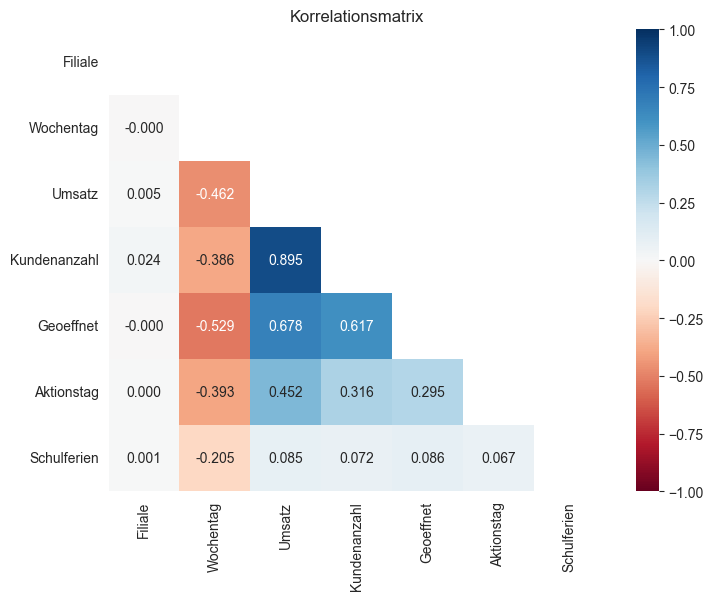

In [96]:
# Spalten mit numerischen Werten
train_only_nr = train.select_dtypes(include=['number'])
corr_matrix = train_only_nr.corr("pearson")
#corr_matrix.style.background_gradient(cmap="Blues", vmin=0, vmax=1)

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(8,6))
plot = sns.heatmap(corr_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Korrelationsmatrix")
plt.show()

### 3.6 Fehlende Werte und Ausreißer <a id="3.6"></a> <br>

- Fehlende Werte: Identifikation und Quantifizierung von fehlenden Datenpunkten.
- Ausreißer: Identifikation von ungewöhnlich hohen oder niedrigen Werten, die nicht dem allgemeinen Muster folgen.

In [97]:
round(train.isnull().sum() / train.shape[0] *100, 2) #Prozent

Filiale         0.0
Wochentag       0.0
Datum           0.0
Umsatz          0.0
Kundenanzahl    0.0
Geoeffnet       0.0
Aktionstag      0.0
Feiertag        0.0
Schulferien     0.0
dtype: float64

#### Datentypen anpassen

In [98]:
dtypes_dict = {"Geoeffnet": bool,
               "Aktionstag": bool,
               "Feiertag": bool,
               "Schulferien": bool}

In [99]:
# Datentypen im Train-Datensatz ändern
train = train.astype(dtypes_dict)
train["Datum"] = pd.to_datetime(train["Datum"])
#train["Wochentag"] = train["Datum"].dt.weekday # Montag=0, Sonntag=6

# Check
print("\nTrain-Datensatztypen nachher")
display(train.dtypes)


Train-Datensatztypen nachher


Filiale                  int64
Wochentag                int64
Datum           datetime64[ns]
Umsatz                   int64
Kundenanzahl             int64
Geoeffnet                 bool
Aktionstag                bool
Feiertag                  bool
Schulferien               bool
dtype: object

#### Tage ohne Umsatz betrachten

Gibt es Datensätze mit 0€ Umsatz? Wenn ja, wann und wieso ist das so?

In [100]:
display(train[train.Umsatz==0.0])

kein_umsatz_anzahl = train[train.Umsatz==0.0].shape[0]

print(str(kein_umsatz_anzahl) + " von " + str(train.shape[0]) + " Zeilen (" + str(round(kein_umsatz_anzahl/train.shape[0]*100,2)) + "%) haben keinen Umsatz.")


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
291,292,5,2015-07-31,0,0,False,True,True,True
875,876,5,2015-07-31,0,0,False,True,True,True
1406,292,4,2015-07-30,0,0,False,True,True,True
1990,876,4,2015-07-30,0,0,False,True,True,True
2521,292,3,2015-07-29,0,0,False,True,True,True
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,False,False,True,True
1017205,1112,2,2013-01-01,0,0,False,False,True,True
1017206,1113,2,2013-01-01,0,0,False,False,True,True
1017207,1114,2,2013-01-01,0,0,False,False,True,True


172871 von 1017209 Zeilen (16.99%) haben keinen Umsatz.


Wir nehmen uns eine zufällige Filiale und schauen uns an, wann kein Umsatz gemacht wurde

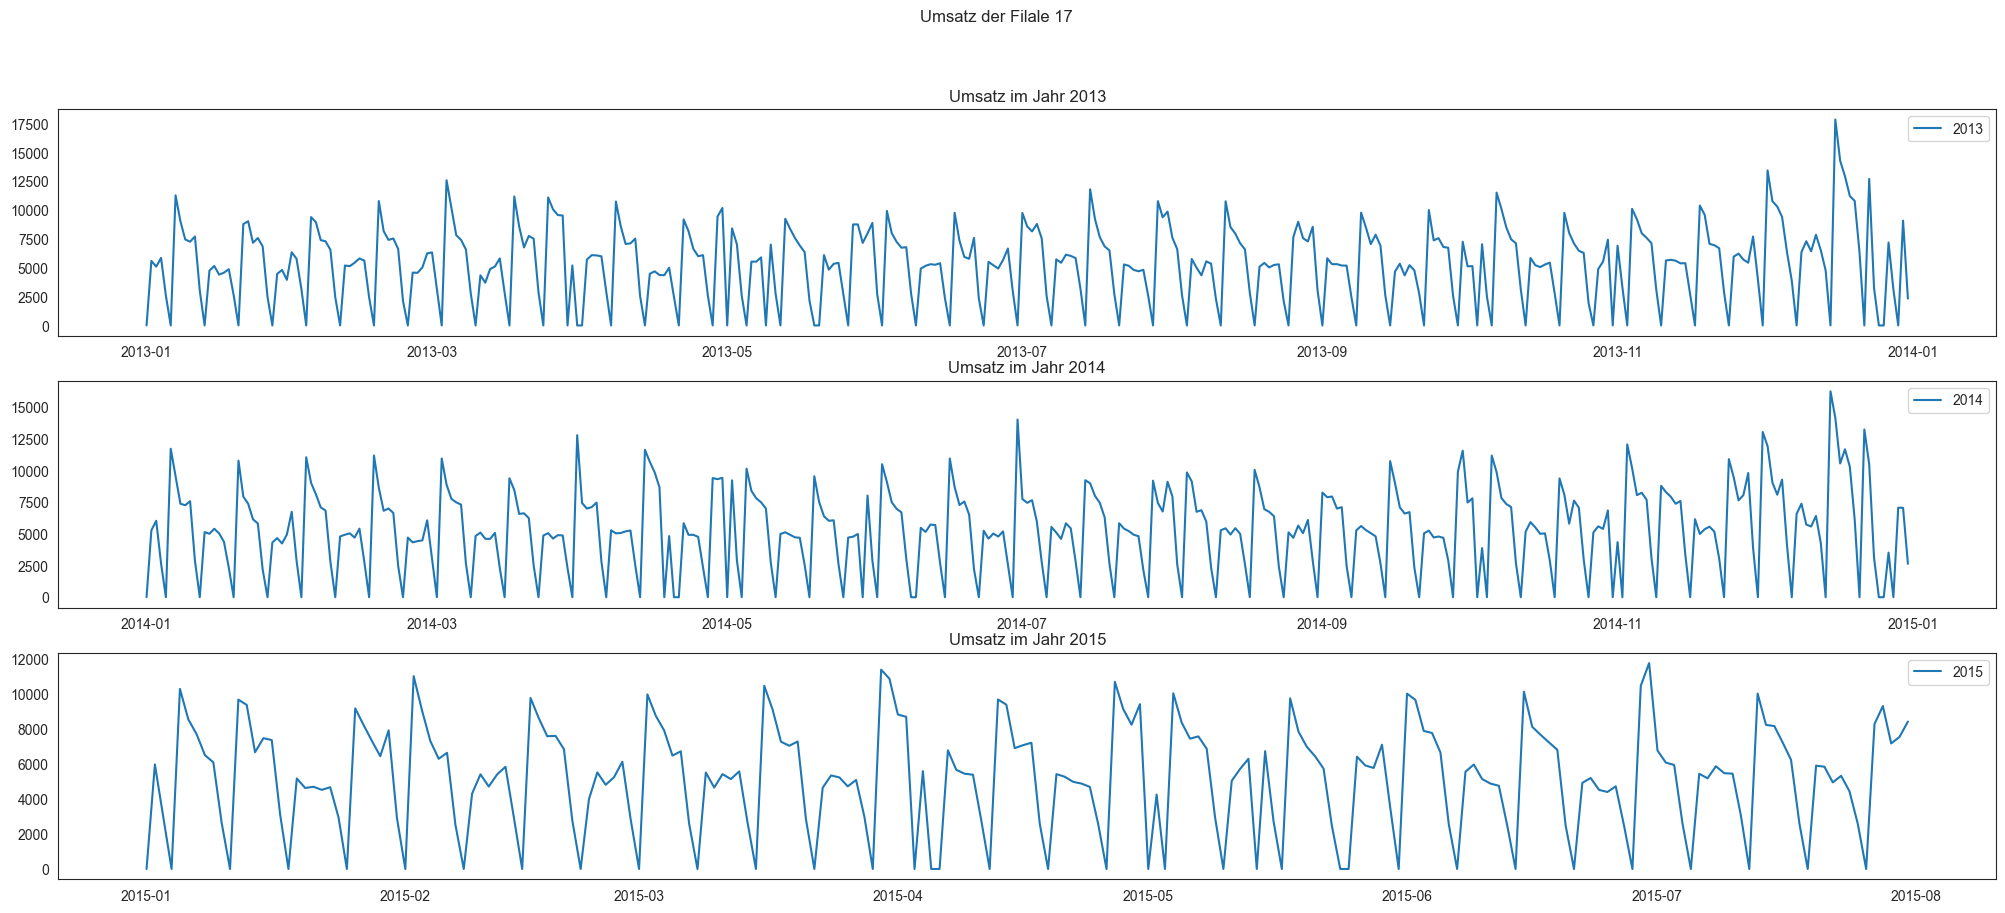

In [101]:
store_id = store["Filiale"].sample(n=1).values[0]
sample = train[train["Filiale"]==store_id].copy()
gp_sample_by_year = sample.groupby(sample["Datum"].dt.year)

fig, axs = plt.subplots(3)
fig.set(figheight = 10, figwidth = 25)
fig.suptitle(f"Umsatz der Filale {store_id}")

for id, sample_year in enumerate(gp_sample_by_year):
    axs[id].plot(sample_year[1]["Datum"], sample_year[1]["Umsatz"], label = sample_year[0])
    axs[id].set_title(f"Umsatz im Jahr {sample_year[0]}")
    axs[id].legend()

plt.show()

In [102]:
# Alle Tage, an denen kein Umsatz gemacht wurde, obwohl die Filiale geöffnet war
kein_umsatz_geoeffnet = train[(train["Umsatz"]==0) & (train["Geoeffnet"]==True)]
kein_umsatz_geoeffnet.head()

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
86825,971,5,2015-05-15,0,0,True,False,True,True
142278,674,4,2015-03-26,0,0,True,False,True,False
196938,699,4,2015-02-05,0,0,True,True,True,False
322053,708,3,2014-10-01,0,0,True,True,True,False
330176,357,1,2014-09-22,0,0,True,False,False,False


In [103]:
kein_umsatz_geoeffnet_grouped = kein_umsatz_geoeffnet.groupby(["Wochentag", "Geoeffnet"]).agg(
    Anzahl_Tage=('Umsatz', 'size'),   # Anzahl der Zeilen
    Umsatz=('Umsatz', 'sum')     # Summe der Umsätze
)

kein_umsatz_geoeffnet_grouped

,,Anzahl_Tage,Umsatz
Wochentag,Geoeffnet,,
1,True,3,0
2,True,6,0
3,True,14,0
4,True,18,0
5,True,7,0
6,True,6,0


#### Leere Werte betrachten

## Daten anpassen <a id="4"></a> <br>

In [104]:
print("Test-Datensatztypen vorher")
display(test.dtypes)

# Datentypen im Test-Datensatz ändern
test = test.astype(dtypes_dict)
test["Datum"] = pd.to_datetime(test["Datum"])
test["Wochentag"] = test["Datum"].dt.weekday # Brauchen wir den Wochentag überhaupt noch als Spalte?

# Check
print("\nTest-Datensatztypen nachher")
display(test.dtypes)

Test-Datensatztypen vorher


ID               int64
Filiale          int64
Wochentag        int64
Datum           object
Geoeffnet      float64
Aktionstag       int64
Feiertag        object
Schulferien      int64
dtype: object


Test-Datensatztypen nachher


ID                      int64
Filiale                 int64
Wochentag               int32
Datum          datetime64[ns]
Geoeffnet                bool
Aktionstag               bool
Feiertag                 bool
Schulferien              bool
dtype: object

## Geeignete Merkmale <a id="4"></a> <br>

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

## Machine Learning Verfahren 1 <a id="5"></a> <br>

### 5.1 XXX <a id="5.1"></a> <br>

### 5.2 Modellgüte <a id="5.2"></a> <br>

## Machine Learning Verfahren 2 <a id="6"></a> <br>

## Vergleich der Machine Learning Verfahren <a id="7"></a> <br>